![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Daily Correlation
</b>
</span>

---
**Notebook version**: `1` (18 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **Description**

- Calculate daily correlation between two time series.
- In example (1), the daily correlation between observed global radiation `Rg_f` (observed value) and potential radiation `SW_IN_POT` (calculated value) is investigated.
    - Both variables are expected to be highly correlated.
    - If correlations are low this could be indivative of problems with the sensor or other issues, e.g., a timestamp shift.
- In example (2), the daily correlation between observed global radiation `Rg_f` (observed value) and air temperature `Tair_f` (observed value) is investigated.

</br>

# **Imports**

In [1]:
import importlib.metadata
from datetime import datetime
import pandas as pd
import warnings
warnings.simplefilter("ignore", UserWarning)
from diive.pkgs.analyses.correlation import daily_correlation
from diive.configs.exampledata import load_exampledata_parquet  # Example data
from diive.pkgs.createvar.potentialradiation import potrad  # Function to calculate potential radiation
from diive.core.plotting.heatmap_xyz import HeatmapPivotXYZ  # Heatmap plot
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.74.0


In [2]:
help(daily_correlation)

Help on function daily_correlation in module diive.pkgs.analyses.correlation:

daily_correlation(s1: pandas.core.series.Series, s2: pandas.core.series.Series, mincorr: float = 0.8, showplot: bool = False) -> pandas.core.series.Series
    Calculate daily correlation between two time series.
    
    Args:
        s1: any time series, timestamp must overlap with *s2*
        s2: any time series, timestamp must overlap with *s1*
        mincorr: minimum absolute correlation, only relevant when *showplot=True*,
            must be between -1 and 1 (inclusive)
            Example: with *0.8* all correlations between -0.8 and +0.8 are considered low,
            and all correlations smaller than -0.8 and higher than +0.8 are considered high.
        showplot: if *True*, show plot of results
    
    Returns:
        series with correlations for each day
    
    - Example notebook available in:
        notebooks/Analyses/DailyCorrelation.ipynb



</br>

# **Load example data**

In [3]:
data_df = load_exampledata_parquet()
data_df = data_df.loc[data_df.index.year == 2022].copy()  # Use only year 2022
data_df

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.043 seconds). Detected time resolution of <30 * Minutes> / 30min 


,ET_f,GPP_CUT_16_f,GPP_CUT_84_f,GPP_CUT_REF_f,GPP_DT_CUT_16,GPP_DT_CUT_84,...,SWC_FF0_0.15_1,Tair_f,Tair_orig,Ustar_CUT_REF_Thres,VPD_f,VPD_orig
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2022-01-01 00:15:00,0.176,1.033,0.591,0.816,0.0,0.0,...,27.288,3.977,3.977,0.288,4.709,4.709
2022-01-01 00:45:00,0.170,1.033,0.593,0.817,0.0,0.0,...,27.288,4.027,4.027,0.288,4.767,4.767
2022-01-01 01:15:00,0.151,1.015,0.558,0.797,0.0,0.0,...,27.288,3.603,3.603,0.288,4.481,4.481
2022-01-01 01:45:00,0.140,0.782,0.527,0.779,0.0,0.0,...,27.288,3.213,3.213,0.288,4.203,4.203
2022-01-01 02:15:00,0.134,0.777,0.517,0.773,0.0,0.0,...,27.290,3.097,3.097,0.288,4.124,4.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,-0.016,0.373,0.203,0.600,0.0,0.0,...,19.572,3.463,3.463,0.288,2.210,2.210
2022-12-31 22:15:00,0.105,-2.379,0.894,-1.433,0.0,0.0,...,19.577,5.283,5.283,0.288,3.327,3.327
2022-12-31 22:45:00,0.220,-0.515,0.926,-0.305,0.0,0.0,...,19.589,5.537,5.537,0.288,3.467,3.467


In [4]:
rg_series = data_df['Rg_f'].copy()  # Observed radiation time series for example (1) and (2)
ta_series = data_df['Tair_f'].copy()  # Observed air temperature time series for example (2)
nee_series = data_df['NEE_CUT_REF_f'].copy()  # Observed net ecosystem exhange of CO2 time series from eddy covariance measurements for example (3)
print("Time series of global radiation in W m-2:")
display(rg_series)
print("\n\nTime series of air temperature in °C:")
display(ta_series)
print("\n\nTime series of net ecosystem exchange of CO2 in µmol CO2 m-2 s-1:")
display(nee_series)

Time series of global radiation in W m-2:


TIMESTAMP_MIDDLE
2022-01-01 00:15:00    0.0
2022-01-01 00:45:00    0.0
2022-01-01 01:15:00    0.0
2022-01-01 01:45:00    0.0
2022-01-01 02:15:00    0.0
                      ... 
2022-12-31 21:45:00    0.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    0.0
2022-12-31 23:15:00    0.0
2022-12-31 23:45:00    0.0
Freq: 30min, Name: Rg_f, Length: 17520, dtype: float64



Time series of air temperature in °C:


TIMESTAMP_MIDDLE
2022-01-01 00:15:00    3.977
2022-01-01 00:45:00    4.027
2022-01-01 01:15:00    3.603
2022-01-01 01:45:00    3.213
2022-01-01 02:15:00    3.097
                       ...  
2022-12-31 21:45:00    3.463
2022-12-31 22:15:00    5.283
2022-12-31 22:45:00    5.537
2022-12-31 23:15:00    4.963
2022-12-31 23:45:00    6.490
Freq: 30min, Name: Tair_f, Length: 17520, dtype: float64



Time series of net ecosystem exchange of CO2 in µmol CO2 m-2 s-1:


TIMESTAMP_MIDDLE
2022-01-01 00:15:00   -0.216
2022-01-01 00:45:00   -0.216
2022-01-01 01:15:00   -0.216
2022-01-01 01:45:00   -0.216
2022-01-01 02:15:00   -0.216
                       ...  
2022-12-31 21:45:00    1.224
2022-12-31 22:15:00    3.518
2022-12-31 22:45:00    2.424
2022-12-31 23:15:00    1.017
2022-12-31 23:45:00    2.281
Freq: 30min, Name: NEE_CUT_REF_f, Length: 17520, dtype: float64

In [5]:
# Calculate potential radiation SW_IN_POT to use as reference in example (1)
reference = potrad(timestamp_index=rg_series.index,
                   lat=47.286417,
                   lon=7.733750,
                   utc_offset=1)
reference

TIMESTAMP_MIDDLE
2022-01-01 00:15:00    0.0
2022-01-01 00:45:00    0.0
2022-01-01 01:15:00    0.0
2022-01-01 01:45:00    0.0
2022-01-01 02:15:00    0.0
                      ... 
2022-12-31 21:45:00    0.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    0.0
2022-12-31 23:15:00    0.0
2022-12-31 23:45:00    0.0
Freq: 30min, Name: SW_IN_POT, Length: 17520, dtype: float64

</br>

# (1) **Calculate daily correlation between `Rg_f` and `SW_IN_POT`**

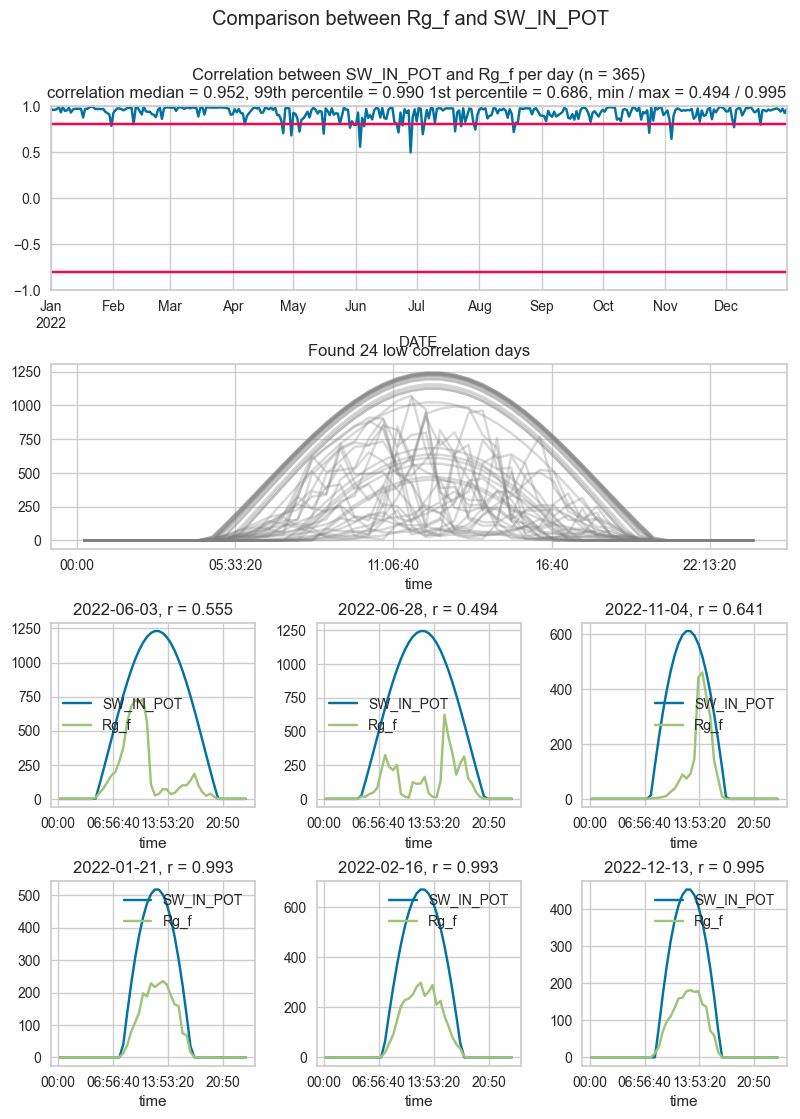

In [6]:
daycorrs = daily_correlation(
    s1=rg_series,
    s2=reference,
    mincorr=0.8,
    showplot=True
)

In [7]:
# All daily correlations
daycorrs

DATE
2022-01-01    0.967678
2022-01-02    0.954463
2022-01-03    0.955140
2022-01-04    0.962414
2022-01-05    0.987641
                ...   
2022-12-27    0.960270
2022-12-28    0.936301
2022-12-29    0.967984
2022-12-30    0.920200
2022-12-31    0.962476
Freq: D, Name: daycorrs, Length: 365, dtype: float64

</br>

# (2) **Calculate daily correlation between `Tair_f` and `Rg_f`**

In [8]:
daycorrs = daily_correlation(
    s1=ta_series,
    s2=rg_series
)

In [9]:
# All daily correlations
daycorrs

DATE
2022-01-01    0.854452
2022-01-02    0.828606
2022-01-03    0.754225
2022-01-04    0.729151
2022-01-05    0.020350
                ...   
2022-12-27    0.270953
2022-12-28    0.578541
2022-12-29    0.475528
2022-12-30    0.294125
2022-12-31    0.705969
Freq: D, Name: daycorrs, Length: 365, dtype: float64

</br>

# (3) **Calculate daily correlation between `Tair_f` and `NEE_CUT_REF_f`**

In [10]:
daycorrs = daily_correlation(
    s1=ta_series,
    s2=nee_series,    
    showplot=False
)

In [11]:
# All daily correlations
daycorrs

DATE
2022-01-01    0.588741
2022-01-02    0.206918
2022-01-03   -0.066644
2022-01-04    0.095609
2022-01-05   -0.237885
                ...   
2022-12-27   -0.304999
2022-12-28   -0.248761
2022-12-29   -0.118126
2022-12-30   -0.291619
2022-12-31   -0.370086
Freq: D, Name: daycorrs, Length: 365, dtype: float64

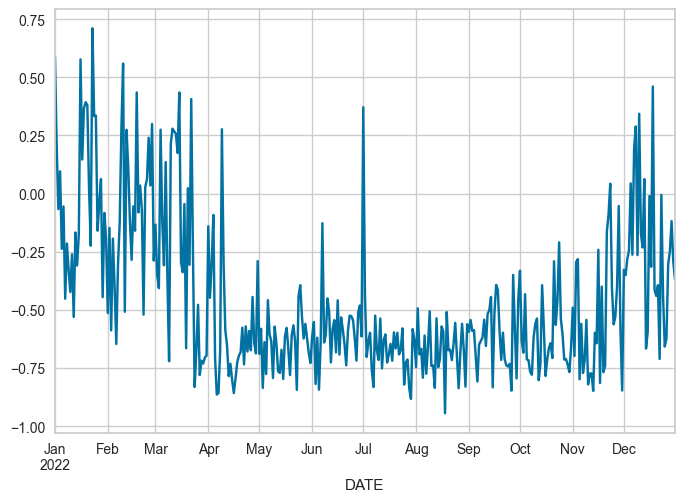

In [12]:
daycorrs.plot();

</br>

# **End of notebook**

In [13]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-04-21 10:21:14
